In [17]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import skew
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from utils.dataManagers.dataSteward import DataSteward
from utils.dataManagers.informations import informer
from utils.predictions import *
from utils.dataManagers.dataWrangler import *
from utils.ClassifierResults import *

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso

In [29]:
ds = DataSteward('mapper_and_most_frequent', 'mean')
column_desc = informer.get_column_descriptions()

train = ds.train_data
test = ds.test_data
ytrain = ds.train_response
ytrain_logged = np.log1p(ytrain)

Data Steward is class containing test and train data. In initialization we can set type of operations on data.
For categorical data I provided options:
* mapper_only:

This option maps categorical data according to value mapping contained in mapper class. For example:
column 'Street' got:
Street_MAPPING = {
    'Grvl': 'Gravel',
    'Pave': 'Paved'
}
Mapper class contains also column descriptions and null values mappings for categorical features. All those informations were extracted from Kaggle competition description. Informer class serves this data as pandas series.
But mapper doesn't have all mappings thus I created:
* mapper_and_most_frequent:

Option fills null values in columns that left with most frequent value across dataset.

For number type data I use Imputer so aviable options are:
 * mean,
 * median,
 * most_frequent
 
 You can obtain not changed values by leaving empty constructor.

All those options are performed on train an test datasets separatly, but filling with values of whole dataset may be a better idea and best I can think of for now is putting values 'content wisely'- look at missing values and decide manually for each of it.

In [5]:
number_type = get_number_types(train)

skew_thresshold = 2
skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= skew_thresshold].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)


Here I exctract dummy variables, and log skewed feature columns by given thresshold.

In [19]:
from sklearn.metrics import mean_squared_log_error
def scoring_function(actual, predicted):
    return np.sqrt(mean_squared_log_error(actual, predicted))

def fit_ensemble(models, ensemble_name, X_train, y_train, X_test, k_folds=5, cv_folds=5):
    ensemble = Ensembler(models, ensemble_name)
    ensemble.fit(X_train, y_train, n_jobs=11, calculate_validation_error_method=scoring_function, k_folds=k_folds, cv_folds=cv_folds)
    results = ensemble.calculate_results_objects(X_train, y_train, X_test, predictions_form_restoring_method=restoring_method, plot_best_results=False, store_predictions_score=True)
    return ensemble, results

Fit_ensemble is a wrapper on my Ensembler class.

Ensembler class contains models, models are in form of class RegressionModel, both can be found in predictions file. **In modeling part You can find way to initialize it and run it. **

Here is more information on how I am doing it.

We want to build different models and compare different algorithms, but if we want to compare them in a propper way we have to evaluate them on the same part of the data, thus we have to use nested cross validation in nested cross validation. This scenario is described by picture below, which comes from Sebastian Raschka [blog post](https://sebastianraschka.com/faq/docs/evaluate-a-model.html).
<img src='https://sebastianraschka.com/images/faq/evaluate-a-model/nested-k-fold.png'></img>

In Ensembler fit method:
* I am **creating k k_fold splits **
(after fitting they can be found in kfold_split_indexes, later Ensembler could have a method add model which would fit new model on those folds).
* **fitting every model given in Ensembler initialization,**
    * we can perform gridSearch or randomSearch(by setting n_iter parameter in RegressionModel creation, to see more about RegressionModel look at it's documentation). This searching algorithms perform cross validation inside and automaticly chooses best performing ones.
    * think about setting different n_jobs parameter (number of jobs to run in parallel), mine is 11.
* calculate mean_squared_error.
    *  because I use double logged output implementation is using np.expm1, but normally It wouldn't look like that. Probably putting method of evaluation in RegressionModel would be a better idea.
* basing on error calculated above I choose best performing hyperparameters and I ** retrain model on whole training dataset.**

We can use ** predict ** method to get predictions directly, or use ** calculate_results_objects ** to gain deeper insight. Method will return ClassifierResults objects that have helpfull methods, one that you should look at is plot_results. Visualization is in my opinion most valuable source of information. This method have most common plots, that we want to see after plotting model. You can also store classifier, get most important and excluded columns. Values of this objects have information about most model parameters, cv results, grid object used in previous step and so on.

In [7]:
def get_best_quantile_columns(feature_importances_column, quantile):
    return list(feature_importances_column[feature_importances_column > feature_importances_column.quantile(quantile)].index)

def get_train_subsets(best_cols, outliers_idx, xtrain, ytrain, xtest):
    return xtrain[~xtrain.index.isin(outliers_idx)].loc[:, best_cols], ytrain[~ytrain.index.isin(outliers_idx)], xtest.loc[:, best_cols]

def restoring_method(val):
    return np.expm1(np.expm1(val))

def get_weights(X):
    cat_cols = X.select_dtypes(['uint8'])
    weights = pd.Series(np.ones(X.shape[0]), index=X.index)
    for col in cat_cols:
        argmin = X[col].value_counts().argmin()
        weights[X.loc[X[col] == argmin].index] += 10
    return pd.Series(weights)

Below we set variables we need to perform calculations.

Outliers_idx are indexes of samples I classified as outliers, feature_importances.csv contains importance of columns based on previous calculations. I've obtain those results by performing fit operations on lasso and xgb models using resampled train data. Outlier was recognized as sample that was out of residual plot 90% for lasso and 95% for xgb. For features importances it is a simple meanof feature_importances_. I've also used boruta method to get another ranking column. After putting this information in dataframe I perform MinMax scalling, add values together and select best 50%. This method should be performed once again if some features are added or null values are filled in another way

I've also created get_weights method- it is used in tree algorithms. Here I simply add more weight to undersampled rows.

In [8]:
outliers_idx = [  31,  186,  411,  463,  496,  524,  582,  589,  633,  667,  689, 711,  969,  971, 1063, 1299, 1325, 1384, 1433, 1454]

feature_importances = pd.read_csv('coefficients/feature_importances.csv', index_col='ColumnName')

cols_to_drop = [
    '_MSZoning_C (all)',
    '_MSSubClass_160',
]

best_cols_quantile = .5
best_cols = get_best_quantile_columns(feature_importances.coef_sum, best_cols_quantile)
best_cols = [v for v in best_cols if v not in cols_to_drop]
X_train, y_train, X_test = get_train_subsets(best_cols, outliers_idx, trainWithDummies, np.log1p(ytrain_logged), testWithDummies)

weights = get_weights(X_train)

# Modeling part

In [9]:
models = []

lasso_param_grid = dict(alpha=[1e-6])
lasso_model = RegressionModel(RegressionResults, Lasso(normalize=False, max_iter=7000), lasso_param_grid, name='lasso')
models.append(lasso_model)

xgb_param_grid = {  
    "n_estimators": [700],
    "max_depth": [3],
    "learning_rate":[.07],
    "colsample_bytree": [.4],
    "subsample": [.5],
    "min_child_weight": [1.5]
}
xgb_model = RegressionModel(TreeResults, xgb.XGBRegressor(), xgb_param_grid, name='xgb_with_weights', weights=weights)
models.append(xgb_model)


xgb_param_grid = {  
    "n_estimators": [700],
    "max_depth": [3],
    "learning_rate":[.07],
    "colsample_bytree": [.4],
    "subsample": [.5],
    "min_child_weight": [1.5]
}
xgb_model = RegressionModel(TreeResults, xgb.XGBRegressor(), xgb_param_grid, name='xgb_without_weights')
models.append(xgb_model)

ensemble_name = f'ensemble_of_lasso_xgb_models_skew_thresshold({skew_thresshold})_best_cols_quantile({best_cols_quantile})'
lasso_xgb_ensemble, lasso_xgb_results = fit_ensemble(models, ensemble_name, X_train, y_train, X_test)

kfold number: 0 for model: lasso, time is: 2017-10-31 16:20:38.450859
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.009056068761756944
kfold number: 0 for model: xgb, time is: 2017-10-31 16:20:45.642563
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.010209421245417603
kfold lap started at: 2017-10-31 16:20:38.448853 and ended at: 2017-10-31 16:20:54.732075, took: 0:00:16.283222
---
kfold number: 1 for model: lasso, time is: 2017-10-31 16:20:54.733579
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.009615113291601871
kfold number: 1 for model: xgb, time is: 2017-10-31 16:21:01.875234
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.011376315470245939
kfold lap started at: 2017-10-31 16:20:54.732577 and ended at: 2017-10-31 16:21:11.089267, took: 0:00:16.356690
---
kfold number: 2 


Here we can see progress and output information about our learning part. For now outliers and results are automaticly stored.
Ensemble_predictions is method to reweight output of selected algorithms, store flag decides weather to store csv file on disc.

In [ ]:
# store_object(lasso_xgb_ensemble, 'lasso_xgb_ensemble')
# store_object(lasso_xgb_results, 'lasso_xgb_results')
# lasso_xgb_ensemble = pickle.load(open('lasso_xgb_ensemble.p', 'rb'))
# lasso_xgb_results = pickle.load(open('lasso_xgb_results.p', 'rb'))

In [28]:
preds = lasso_xgb_ensemble.ensemble_predictions([.6, .4], store=True)
preds.head()

,SalePrice
Id,
1461,127460.144908
1462,160356.811954
1463,194838.918827
1464,202721.948697
1465,181859.461050


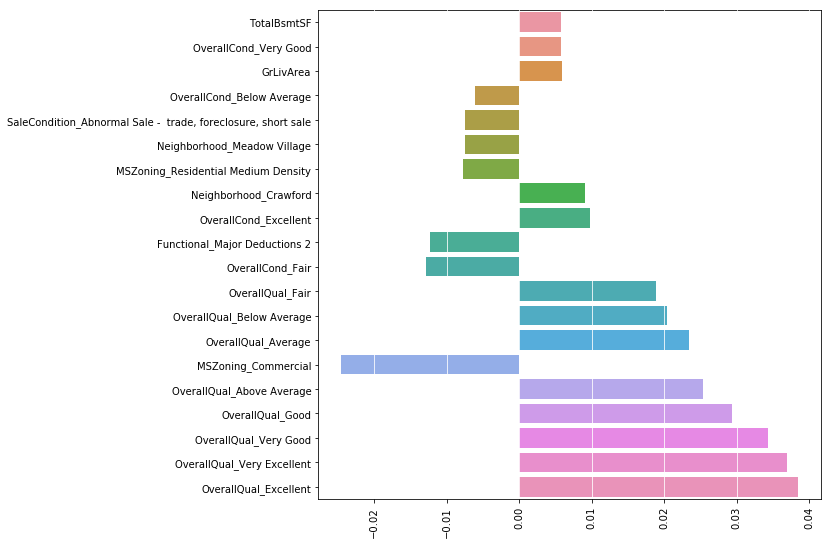

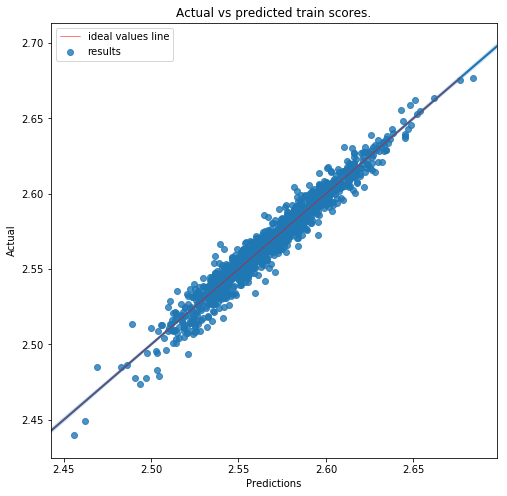

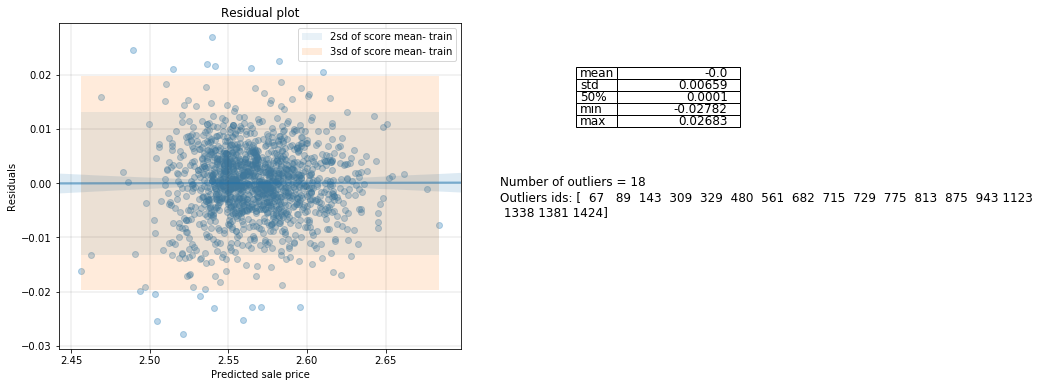

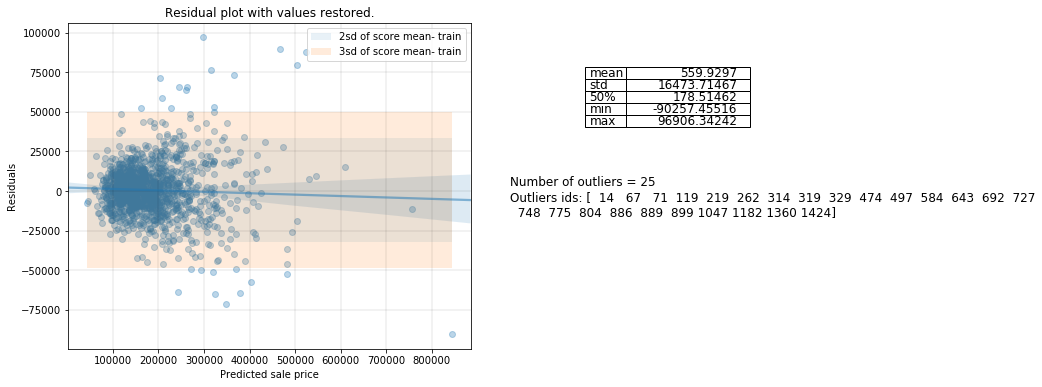

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


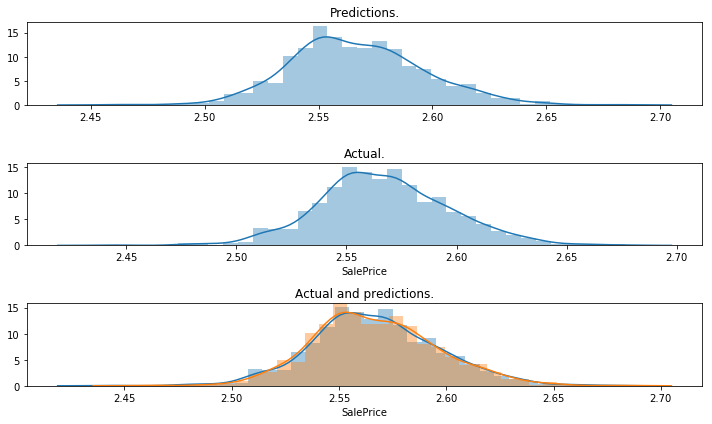

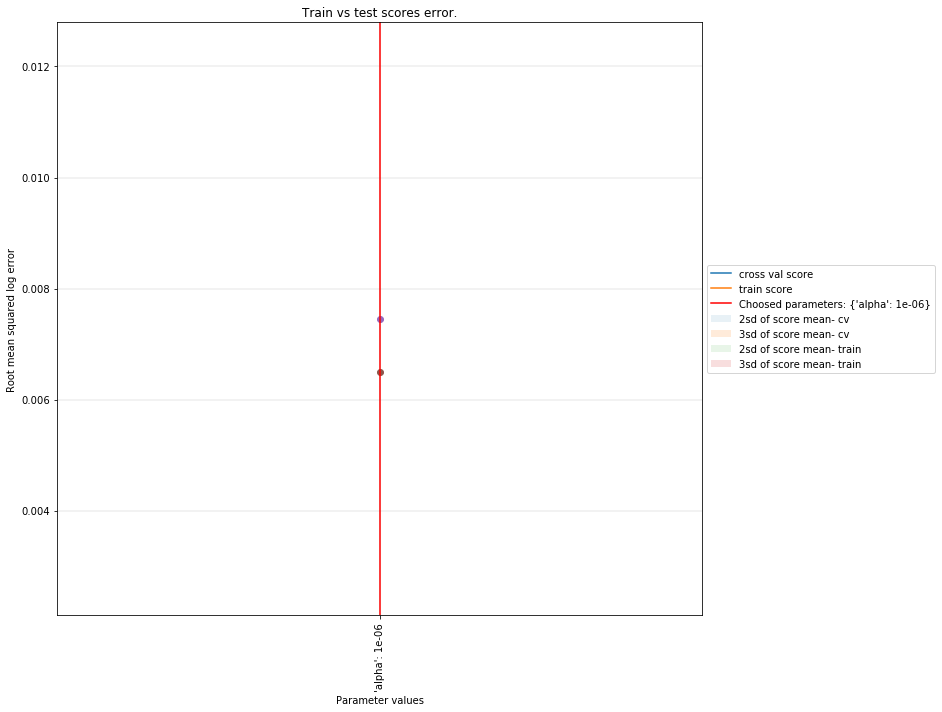

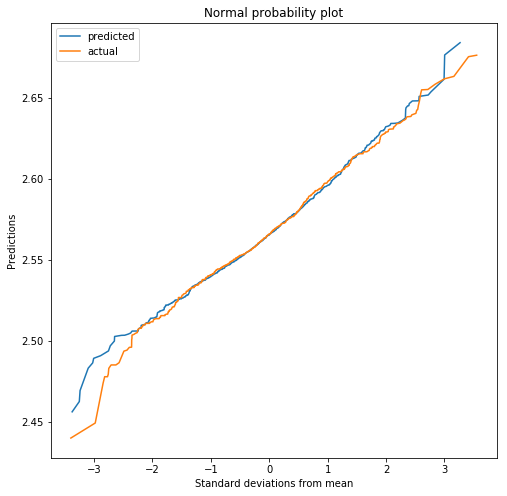

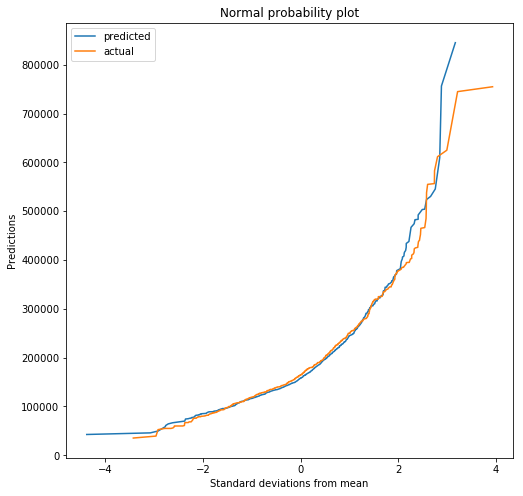

In [11]:
lasso_xgb_results[0].plot_results()

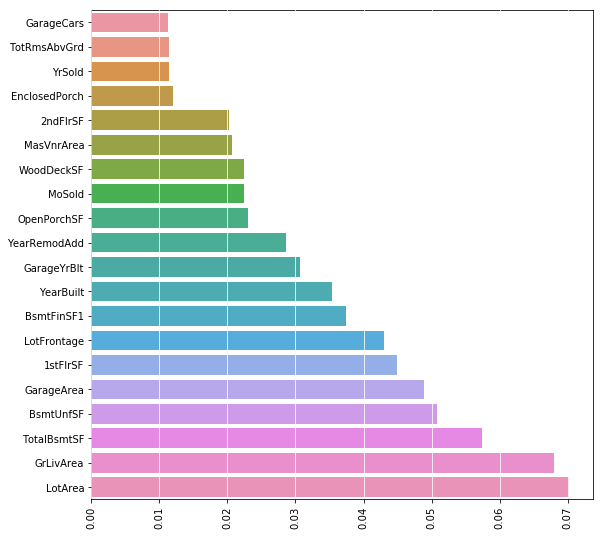

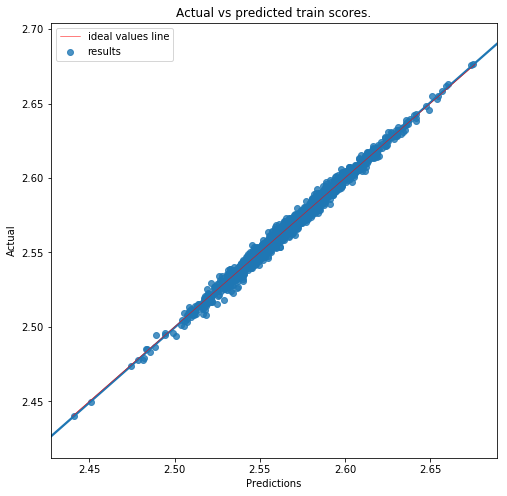

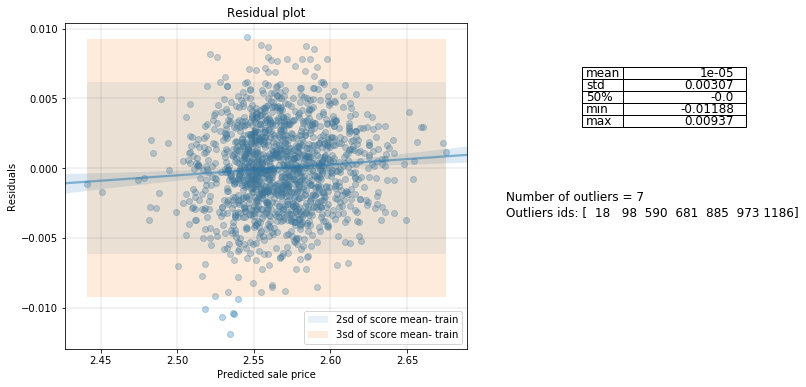

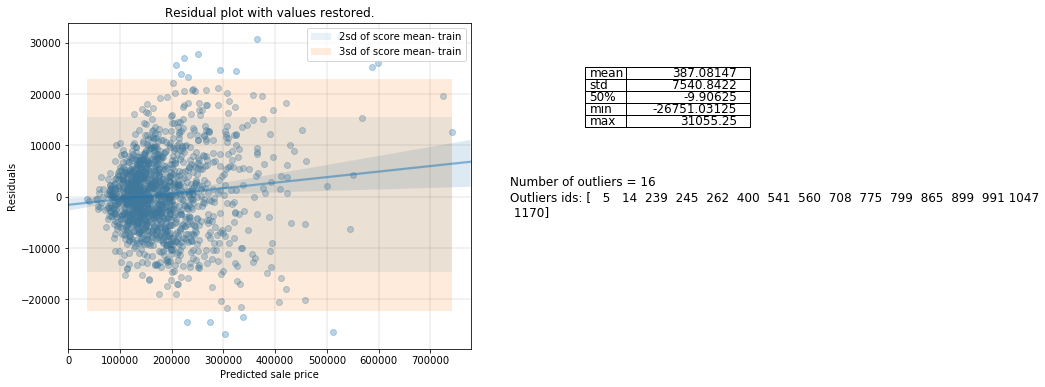

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


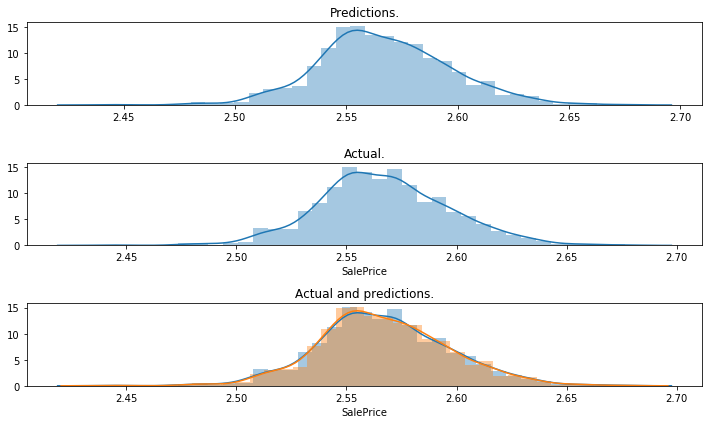

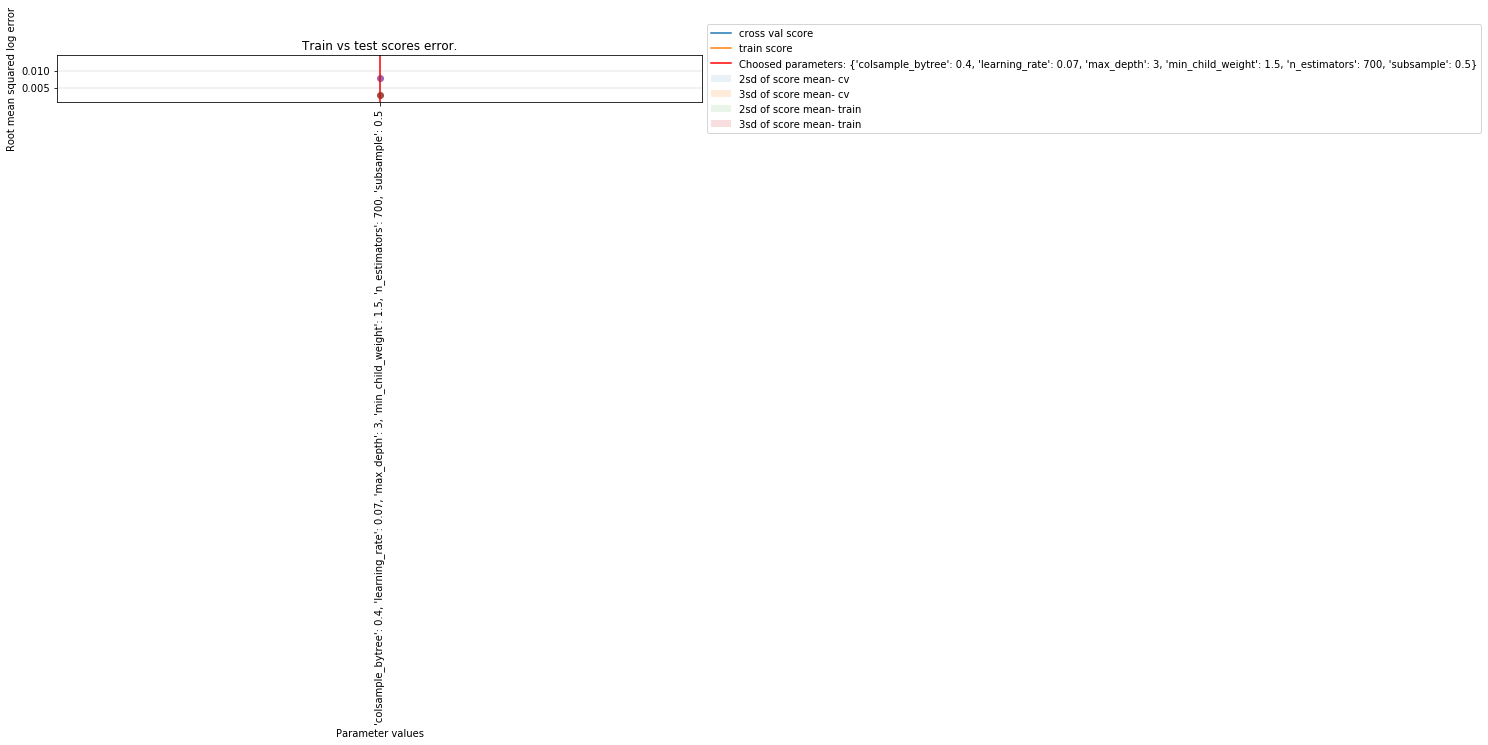

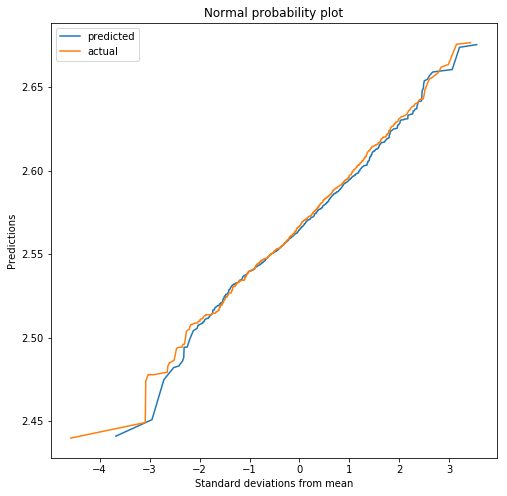

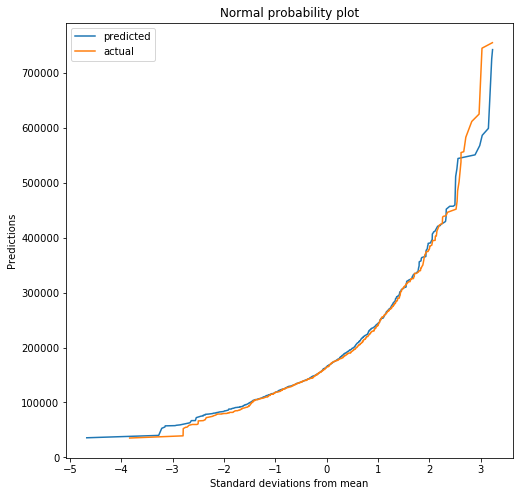

In [14]:
lasso_xgb_results[1].plot_results()

In [15]:
from sklearn.linear_model import Ridge, ElasticNet

models = []

lasso_param_grid = dict(alpha=[1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4])
lasso_model = RegressionModel(RegressionResults, Lasso(normalize=False, max_iter=5000), lasso_param_grid, name='lasso')
models.append(lasso_model)

ridge_param_grid = dict(alpha=[1e-4, 1e-3, 1e-2, .1, 1, 3])
ridge_model = RegressionModel(RegressionResults, Ridge(normalize=False, max_iter=5000), ridge_param_grid, name='ridge')
models.append(ridge_model)

elasticNet_param_grid = dict(alpha=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2], l1_ratio=[.01, .1, .5, .9, .99])
elasticNet_model = RegressionModel(RegressionResults, ElasticNet(normalize=False, max_iter=5000), elasticNet_param_grid, name='ElasticNet')
models.append(elasticNet_model)

rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [15, 20, 30, 50], 'max_features': ['sqrt']}
rf_model = RegressionModel(TreeResults, RandomForestRegressor(), rf_param_grid, name='random_forest')
models.append(rf_model)

xgb_param_grid = {  
    "n_estimators": [500, 700],
    "max_depth": [3],
    "learning_rate":[.07, .075],
    "colsample_bytree": [.4, .5],
    "subsample": [.5],
    "min_child_weight": [1.5]
}
xgb_model = RegressionModel(TreeResults,  xgb.XGBRegressor(), xgb_param_grid, name='xgb')
models.append(xgb_model)

en = Ensembler(models, f'ensemble of {len(models)} models skew_thresshold({skew_thresshold})_best_cols_quantile({best_cols_quantile})')
en.fit(X_train, y_train)
results = en.calculate_results_objects(X_train, y_train, X_test, predictions_form_restoring_method=restoring_method, plot_best_results=False)


kfold number: 0 for model: lasso, time is: 2017-10-31 16:46:32.248458
Performing GridSearchCV.


c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Current mean_squared_error on validation set(logged pred and output) is: 0.009034861939752536
kfold number: 0 for model: ridge, time is: 2017-10-31 16:46:49.331057
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0090339360202505
kfold number: 0 for model: ElasticNet, time is: 2017-10-31 16:47:05.708650
Performing GridSearchCV.


c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Current mean_squared_error on validation set(logged pred and output) is: 0.00903483550202969
kfold number: 0 for model: random_forest, time is: 2017-10-31 16:47:27.598277
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.01355902963342189
kfold number: 0 for model: xgb, time is: 2017-10-31 16:47:49.229189
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.009688079272261375
kfold lap started at: 2017-10-31 16:46:32.246953 and ended at: 2017-10-31 16:48:10.446548, took: 0:01:38.199595
---
kfold number: 1 for model: lasso, time is: 2017-10-31 16:48:10.448052
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.010317348846760646
kfold number: 1 for model: ridge, time is: 2017-10-31 16:48:25.476338
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.01040122877800215
kfold number: 1 for model: Elas

c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Current mean_squared_error on validation set(logged pred and output) is: 0.009857522352107686
kfold number: 2 for model: ridge, time is: 2017-10-31 16:49:57.637145
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.009291252978884293
kfold number: 2 for model: ElasticNet, time is: 2017-10-31 16:50:14.108232
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.009187768123143482
kfold number: 2 for model: random_forest, time is: 2017-10-31 16:50:35.654250
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.017797833096884
kfold number: 2 for model: xgb, time is: 2017-10-31 16:50:56.771736
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.00946862764762449
kfold lap started at: 2017-10-31 16:49:40.692291 and ended at: 2017-10-31 16:51:17.342915, took: 0:01:36.650624
---
kfold number: 3 for model: 

c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Current mean_squared_error on validation set(logged pred and output) is: 0.00943734138796451
kfold number: 4 for model: ridge, time is: 2017-10-31 16:53:05.113994
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.009436912874880141
kfold number: 4 for model: ElasticNet, time is: 2017-10-31 16:53:20.498835
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.009403993750072738
kfold number: 4 for model: random_forest, time is: 2017-10-31 16:53:41.089414
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.015945996911488697
kfold number: 4 for model: xgb, time is: 2017-10-31 16:54:01.507395
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.011354305882061386
kfold lap started at: 2017-10-31 16:52:49.672956 and ended at: 2017-10-31 16:54:22.258053, took: 0:01:32.585097
---
Refitting model lasso
Be

c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Refitting model ridge
Best validation error for model: ridge is: 0.008239188662826944, chosen parameters are: {'alpha': 0.0001}
Refitting model ElasticNet
Best validation error for model: ElasticNet is: 0.009022748045759546, chosen parameters are: {'alpha': 1e-05, 'l1_ratio': 0.9}


c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Refitting model random_forest
Best validation error for model: random_forest is: 0.01355902963342189, chosen parameters are: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 300}
Refitting model xgb
Best validation error for model: xgb is: 0.008312208555236256, chosen parameters are: {'colsample_bytree': 0.5, 'learning_rate': 0.075, 'max_depth': 3, 'min_child_weight': 1.5, 'n_estimators': 700, 'subsample': 0.5}

Calculations started at: 2017-10-31 16:46:32.246452 and ended at 2017-10-31 16:55:56.291017, took: 0:09:24.044565


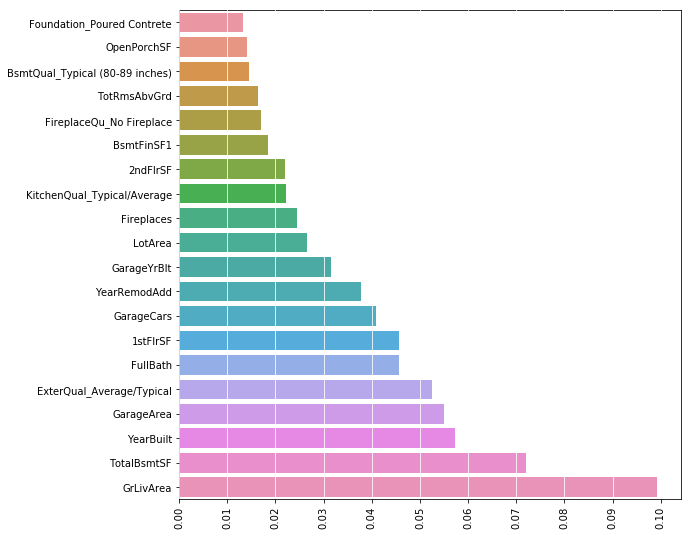

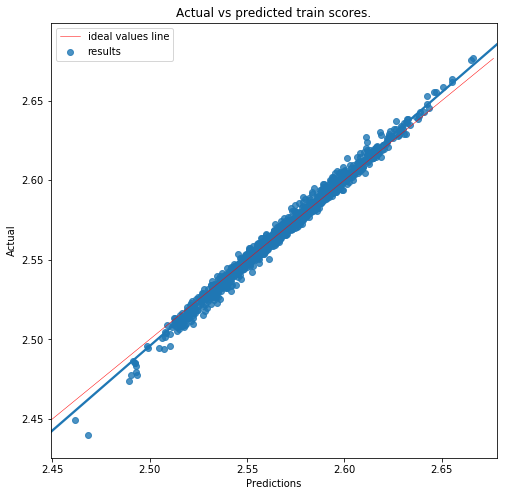

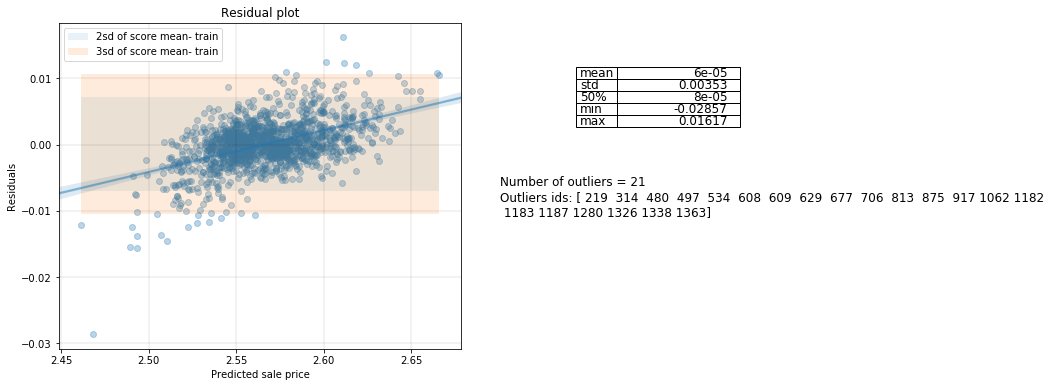

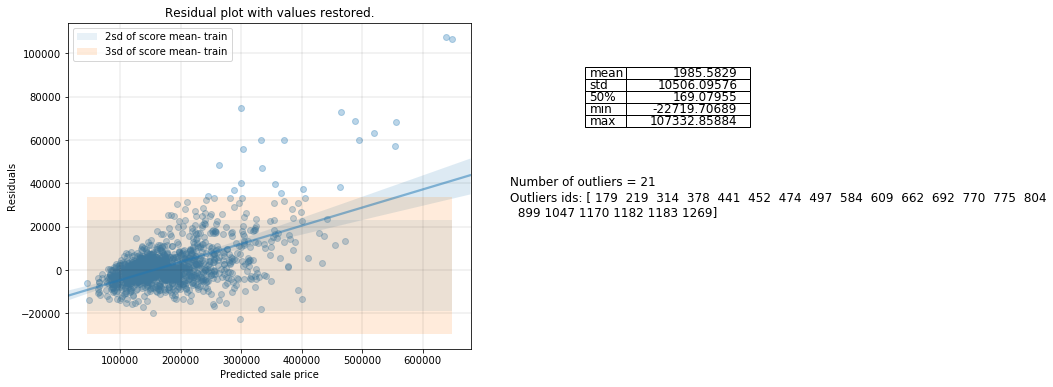

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


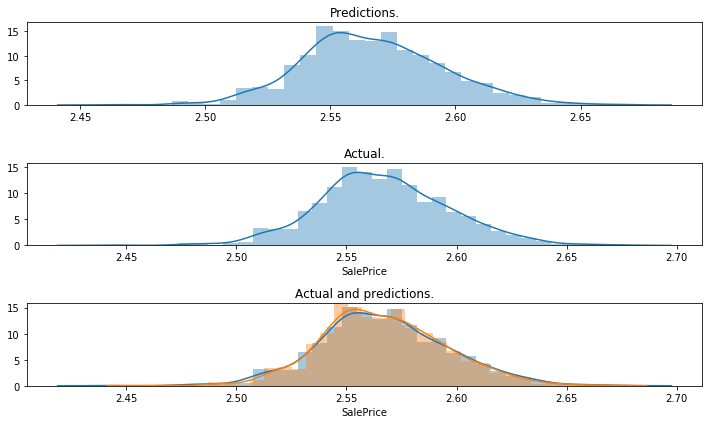

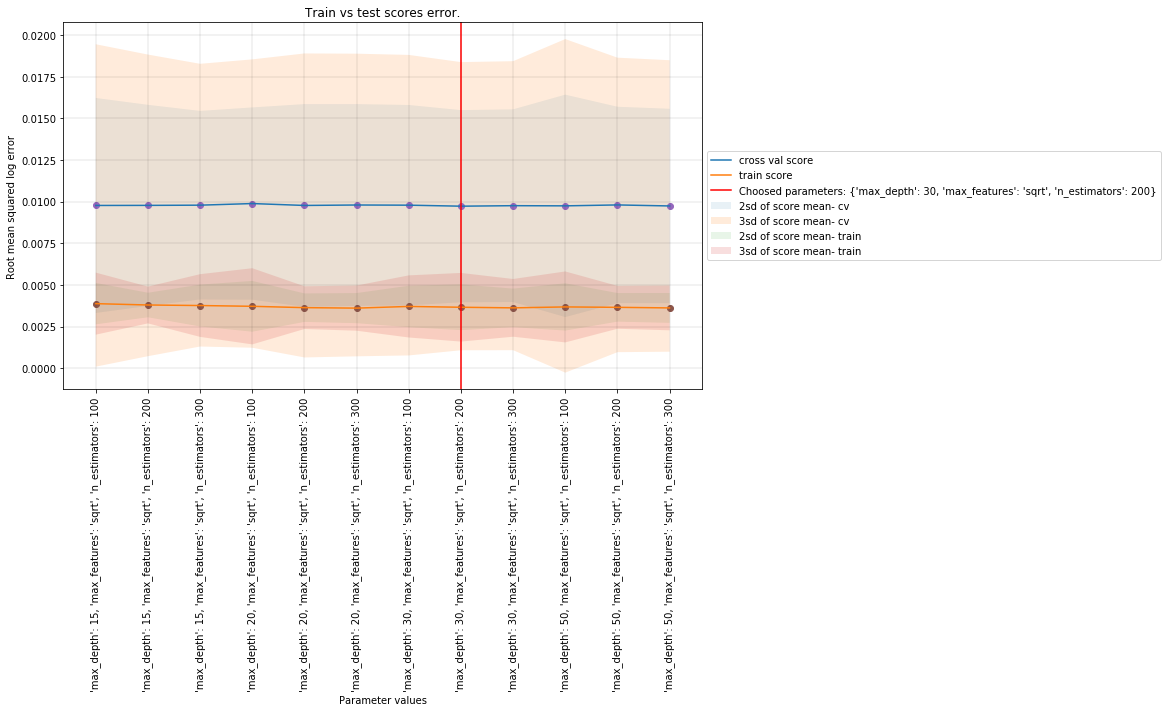

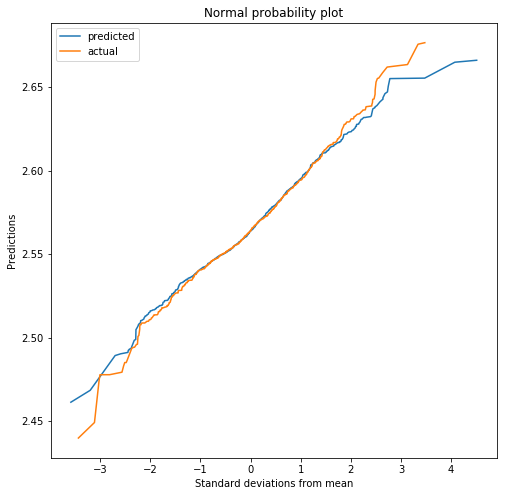

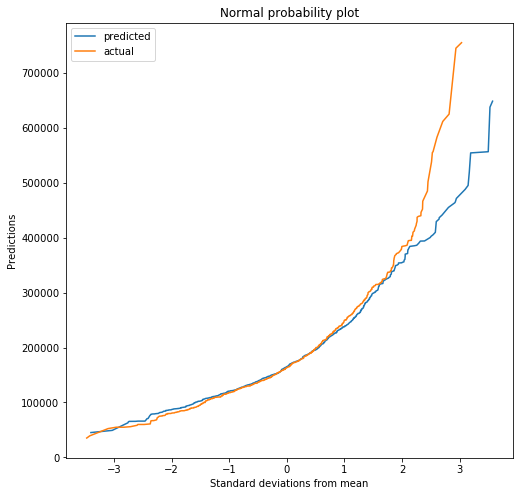

In [5]:
results[3].plot_results()